#### This notebook presents how to perform maximum-likelihood parameter estimation for multiple neurons. 
#### For testing the concept we use 2 neurons for which we have stored the responses to a given stimulus. 

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import csv
%matplotlib inline

In [20]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(),".."))
sys.path.append(os.path.join(os.getcwd(),"..","code"))

In [21]:
import filters
import likelihood_functions as lk
import PoissonProcessClasses as PP
import auxiliary_functions as auxfun

In [22]:
import imp
imp.reload(filters)
imp.reload(lk)
imp.reload(auxfun)
imp.reload(PP)

<module 'PoissonProcessClasses' from '/Users/val/MEGAsync/GLM_PythonModules/notebooks/../code/PoissonProcessClasses.py'>

In [23]:
# Number of neurons
nofCells = 2

Reading input-output data:

In [24]:
# creating the path to the data
data_path = os.path.join(os.getcwd(),'..','data')

# reading stimulus
Stim = np.array(pd.read_csv(os.path.join(data_path,'Stim.csv'),header = None))

# reading location of spikes
# (lengths of tsp sequences are not equal so reading them line by line)
tsp_list = []
with open(os.path.join(data_path,'tsp2.csv')) as csvfile:
    tspreader = csv.reader(csvfile)
    for row in tspreader:
        tsp_list.append(row)

Extracting a spike train from spike positions:

In [25]:
dt = 0.01
y_list = []
for tsp in tsp_list:
    tsp = np.array(tsp).astype(np.float)
    tsp_int = np.ceil((tsp - dt*0.001)/dt)
    tsp_int = np.reshape(tsp_int,(tsp_int.shape[0],1))
    tsp_int = tsp_int.astype(int)
    y_list.append(np.array([item in tsp_int for item in np.arange(Stim.shape[0]/dt)]).astype(int))

Creating filters:

In [26]:
# create a stimulus filter
kpeaks = np.array([0,round(20/3)])
pars_k = {'neye':5,'n':5,'kpeaks':kpeaks,'b':3}
K,K_orth,kt_domain = filters.createStimulusBasis(pars_k, nkt = 20) 

In [27]:
# create a post-spike filter
hpeaks = np.array([0.1,2])
pars_h = {'n':5,'hpeaks':hpeaks,'b':.4}
H,H_orth,ht_domain = filters.createPostSpikeBasis(pars_h,dt)

Conditional Intensity (spike rate):

$$\lambda_{\beta}(i) = \exp(K(\beta_k)*Stim + H(\beta_h)*y_i + \sum_{j\ne i}I({\beta_{I}}_j)*y_j$$

$I(\beta_{I_j})$ corresponds to an interpolating filter with basis $I$ and  coefficients $\beta_{I_j}$ associated with the $y_j$ output. It is to assume that the post-spike history basis and the interpolating bases are the same: $H = I$. The intensity can then be rewritten as 

$$\lambda_{\beta}(i) = \exp\left(M_k \beta_k + \sum_{j=1}^n M_h {\beta_h}_j\right)$$

Creating a matrix of covariates:

<!---Simulating a neuron spike trains:-->

In [28]:
M_k = lk.construct_M_k(Stim,K,dt)

In [29]:
# creating a H-matrix for each response and merging them in one covariate matrix M_h
M_h_list = []
for tsp in tsp_list:
    tsp = np.array(tsp).astype(np.float)
    M_h_list.append(lk.construct_M_h(tsp,H_orth,dt,Stim))

M_h = np.hstack(tuple(M_h_list))

In [30]:
# combining all covariate matrices
M = np.hstack((M_k,M_h))

Conditional intensity as a function of the covariates:
$$ \lambda_{\beta} = \exp(M\beta) $$

Create a Poisson process model with this intensity:

In [31]:
model = PP.PPModel(M.T,dt = dt)

Setting initial parameters:

In [32]:
coeff_k0 = np.array([ 0.061453,0.284916,0.860335,1.256983,0.910615,0.488660,-0.887091,0.097441,0.026607,-0.090147])

coeff_h0 = np.zeros((5*nofCells,))

pars0 = np.hstack((coeff_k0,coeff_h0))

Fitting the likelihood for each neuron:

In [33]:
res_list = []
for y in y_list:
    res_list.append(model.fit(y,start_coef = pars0,method = 'Nelder-Mead'))

137.97542958
137.995567537
138.631471405
141.729921607
145.285288398
142.09925536
137.291205084
143.434684692
137.383295462
137.876368268
138.682214615
137.975411123
137.97596092
137.973974607
137.972771917
137.971853583
137.9755561
137.975382596
137.975396477
137.975396734
137.975467362
132.353889392
126.475058586
132.610847278
132.700126859
132.182870223
134.323062081
133.96693356
134.171956457
133.816940381
133.41035977
132.964634361
132.476497349
131.942194872
131.357640234
130.718472506
130.020013115
129.258806311
128.428047478
127.522014807
126.629564222
126.056386946
120.851725312
124.542492502
126.329941662
125.674607659
125.088237042
124.3744225
123.883173032
123.423183585
122.879833323
122.107874657
121.083097256
120.33914013
114.993909283
118.873984229
118.220203208
117.612910782
117.066098581
116.594285566
116.217799652
115.9589161
115.745394073
114.99629699
113.886727502
108.215392783
112.821918016
112.18458435
111.596452044
110.479956193
109.664677105
108.791682648
108.02

/Users/val/MEGAsync/GLM_PythonModules/notebooks/../code/PoissonProcessClasses.py:184: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if start_coef==None:
/Users/val/anaconda/lib/python3.4/site-packages/scipy/optimize/_minimize.py:358: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  RuntimeWarning)
/Users/val/anaconda/lib/python3.4/site-packages/scipy/optimize/_minimize.py:362: RuntimeWarning: Method Nelder-Mead does not use Hessian information (hess).
  RuntimeWarning)


In [34]:
[print('\n Optimization results:\n'+str(res)) for res in res_list]


 Optimization results:
 success: True
  status: 0
       x: array([  1.12455985e-02,   1.29205868e-01,  -9.57270910e-02,
         2.45506229e-02,  -3.85537790e-02,   2.81105175e-02,
         1.90529685e-02,  -2.61217370e-02,   1.19660041e-01,
        -1.37532987e-01,   1.23211386e+01,  -1.42029611e+00,
         1.45297358e+01,   8.68606073e+00,   2.25402306e+01,
        -3.39917210e+01,  -1.39211220e+01,  -2.51909876e+01,
        -9.37934679e+00,  -8.55118937e+00])
 message: 'Optimization terminated successfully.'
     nit: 5483
     fun: -393.23268666396456
    nfev: 7032

 Optimization results:
 success: False
  status: 1
       x: array([  5.78937659e-02,   1.97391662e-01,   1.48964211e-02,
        -6.50801760e-01,   4.63101460e-02,   8.14487477e-01,
        -1.03695346e+00,   4.78749054e-01,  -2.99915831e-01,
         2.86336780e-01,  -1.34421008e+01,  -4.85391961e+00,
        -1.69096550e+01,   3.80151622e+00,   5.49968556e+00,
         1.55990627e+01,   7.40401804e+00,   2.83617

[None, None]

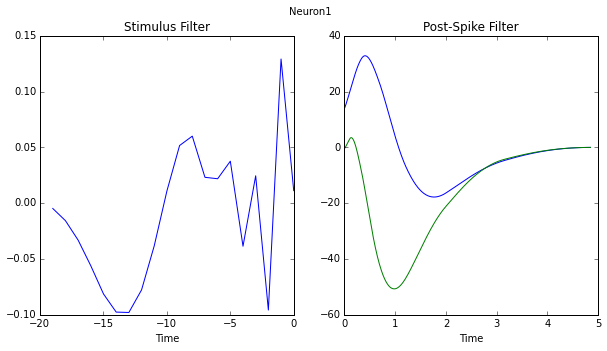

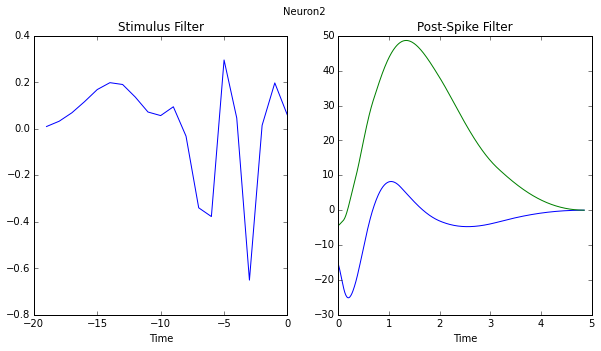

In [35]:
for i in range(len(res_list)):
    k_coeff_predicted = res_list[i].x[:10]
    h_coeff_predicted = np.reshape(res_list[i].x[10:],(H.shape[1],nofCells))
    

    fig,axs = plt.subplots(1,2,figsize = (10,5))
    fig.suptitle('Neuron%d'%(i+1))
    axs[0].plot(-kt_domain[::-1],np.dot(K,k_coeff_predicted))
    axs[0].set_title('Stimulus Filter')
    axs[0].set_xlabel('Time')
    axs[1].plot(ht_domain,np.dot(H,h_coeff_predicted))
    axs[1].set_title('Post-Spike Filter')
    axs[1].set_xlabel('Time')
  